In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import optuna
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
train = pd.read_csv('../input/digit-recognizer/train.csv') 
test = pd.read_csv('../input/digit-recognizer/test.csv')

**The objective of this nootebok will be to create and optimize the hyperparameters of a neural network intended to distinguish digits, the goal is to reach a level of accuracy higher than 98.5%.**

In [3]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [4]:
# Transform data
X_train = (train.iloc[:,1:].values).astype('float32') 
y_train = train.iloc[:,0].values
X_test = test.values.astype('float32')

In [5]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, 
                                                    test_size = 0.20,
                                                    train_size = 0.80,
                                                    random_state = 0,
                                                    stratify= y_train)
print(X_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


In [6]:
# Reshape data
img_rows, img_cols = 28, 28
num_classes = 10

In [7]:
# We process the data and convert it into a 28 x 28 matrix.
X_train = X_train2.reshape(X_train2.shape[0], img_rows, img_cols,1)
X_test = X_test2.reshape(X_test2.shape[0], img_rows, img_cols,1)

y_train = tf.keras.utils.to_categorical(y_train2, num_classes)
print(X_train.shape)

(33600, 28, 28, 1)


In [8]:
# Model CNN
def create_model(num_layer, mid_units, num_filters,dropout_rate):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(3, 3),
                 activation="relu",
                 input_shape=(img_rows, img_cols, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(3,3), padding="same", activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate[0]))
    model.add(Flatten())
    model.add(Dense(mid_units))
    model.add(Dropout(dropout_rate[1]))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [9]:
def objective(trial):
    # Clear session
    keras.backend.clear_session()
    
    # Number of layers
    num_layer = trial.suggest_int("num_layer", 2, 5)
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 100))
    
    # Number of filters in each convolution layer
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
                   for i in range(num_layer)]
    
    # Dropout
    dropout_rate = [0] * 2
    dropout_rate[0] = trial.suggest_uniform('dropout_rate'+str(0), 0.0, 0.5)
    dropout_rate[1] = trial.suggest_uniform('dropout_rate'+str(1), 0.0, 0.5)
    
    #Optimizer
    optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam"])
    
    model = create_model(num_layer, mid_units, num_filters,dropout_rate)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["acc"])
    
    history = model.fit(X_train, y_train, verbose=0, epochs=20,
                        batch_size=128, validation_split=0.1)
    
    scores = model.evaluate(X_train, y_train)
    print('accuracy={}'.format(*scores))
    
    # Find the hyperparameters that maximize the percentage of correct responses to the data for validation
    return 1 - history.history["val_acc"][-1]

In [10]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2022-07-13 11:59:07,863] A new study created in memory with name: no-name-22bea215-3881-4f87-8ade-3738d855fdef
2022-07-13 11:59:07.964531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 11:59:08.073053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 11:59:08.073857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 11:59:08.075169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critica

1050/1050 [==============================] - 3s 3ms/step - loss: 0.0557 - acc: 0.9818


[I 2022-07-13 11:59:43,624] Trial 0 finished with value: 0.01904761791229248 and parameters: {'num_layer': 5, 'mid_units': 100.0, 'num_filter_0': 32.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 48.0, 'num_filter_4': 32.0, 'dropout_rate0': 0.27828689284181335, 'dropout_rate1': 0.37117361529060827, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.01904761791229248.


accuracy=0.055711522698402405
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0203 - acc: 0.9942


[I 2022-07-13 12:00:15,319] Trial 1 finished with value: 0.016071438789367676 and parameters: {'num_layer': 3, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'dropout_rate0': 0.00935901243384435, 'dropout_rate1': 0.07322258226942924, 'optimizer': 'adam'}. Best is trial 1 with value: 0.016071438789367676.


accuracy=0.02030150592327118
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0218 - acc: 0.9947


[I 2022-07-13 12:00:44,438] Trial 2 finished with value: 0.011904776096343994 and parameters: {'num_layer': 4, 'mid_units': 100.0, 'num_filter_0': 16.0, 'num_filter_1': 64.0, 'num_filter_2': 128.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.1788223437062113, 'dropout_rate1': 0.11550078007494952, 'optimizer': 'adam'}. Best is trial 2 with value: 0.011904776096343994.


accuracy=0.021754369139671326
1050/1050 [==============================] - 3s 2ms/step - loss: 0.0194 - acc: 0.9941


[I 2022-07-13 12:01:10,276] Trial 3 finished with value: 0.013095259666442871 and parameters: {'num_layer': 2, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'dropout_rate0': 0.3970480853552237, 'dropout_rate1': 0.31075617390899396, 'optimizer': 'adam'}. Best is trial 2 with value: 0.011904776096343994.


accuracy=0.019375115633010864
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0066 - acc: 0.9987


[I 2022-07-13 12:01:46,724] Trial 4 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 32.0, 'num_filter_3': 48.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.1886175667881292, 'dropout_rate1': 0.08239516787835971, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.006602724082767963
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0104 - acc: 0.9971


[I 2022-07-13 12:02:20,410] Trial 5 finished with value: 0.012499988079071045 and parameters: {'num_layer': 4, 'mid_units': 100.0, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'num_filter_2': 16.0, 'num_filter_3': 128.0, 'dropout_rate0': 0.03892494848529504, 'dropout_rate1': 0.1738371730509758, 'optimizer': 'adam'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.010370785370469093
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0116 - acc: 0.9962


[I 2022-07-13 12:03:07,497] Trial 6 finished with value: 0.010714292526245117 and parameters: {'num_layer': 4, 'mid_units': 100.0, 'num_filter_0': 48.0, 'num_filter_1': 16.0, 'num_filter_2': 80.0, 'num_filter_3': 80.0, 'dropout_rate0': 0.24194437479279102, 'dropout_rate1': 0.42963473010415876, 'optimizer': 'adam'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.011563547886908054
1050/1050 [==============================] - 2s 2ms/step - loss: 2.3012 - acc: 0.1112


[I 2022-07-13 12:03:25,501] Trial 7 finished with value: 0.8943452388048172 and parameters: {'num_layer': 2, 'mid_units': 200.0, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'dropout_rate0': 0.09821138754053826, 'dropout_rate1': 0.1952554474644152, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=2.301173686981201
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:04:07,137] Trial 8 finished with value: 0.9014880955219269 and parameters: {'num_layer': 5, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 64.0, 'num_filter_2': 112.0, 'num_filter_3': 128.0, 'num_filter_4': 32.0, 'dropout_rate0': 0.20166310242485008, 'dropout_rate1': 0.14466360189989247, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0214 - acc: 0.9940


[I 2022-07-13 12:04:36,946] Trial 9 finished with value: 0.014583349227905273 and parameters: {'num_layer': 2, 'mid_units': 100.0, 'num_filter_0': 112.0, 'num_filter_1': 128.0, 'dropout_rate0': 0.2749254503039769, 'dropout_rate1': 0.08005786079834637, 'optimizer': 'adam'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.021433278918266296
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0545 - acc: 0.9818


[I 2022-07-13 12:05:15,347] Trial 10 finished with value: 0.02529764175415039 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 128.0, 'num_filter_2': 48.0, 'num_filter_3': 16.0, 'num_filter_4': 128.0, 'dropout_rate0': 0.46951993866173025, 'dropout_rate1': 0.0007535036249653876, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.05445941910147667
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0210 - acc: 0.9933


[I 2022-07-13 12:06:02,591] Trial 11 finished with value: 0.01220238208770752 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 16.0, 'num_filter_2': 64.0, 'num_filter_3': 80.0, 'dropout_rate0': 0.3566080423713403, 'dropout_rate1': 0.4958865498669879, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.02101047895848751
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0123 - acc: 0.9959


[I 2022-07-13 12:06:26,444] Trial 12 finished with value: 0.014285743236541748 and parameters: {'num_layer': 3, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 32.0, 'num_filter_2': 80.0, 'dropout_rate0': 0.1471837048080266, 'dropout_rate1': 0.4961261031874953, 'optimizer': 'adam'}. Best is trial 4 with value: 0.00952380895614624.


accuracy=0.01230879221111536
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0104 - acc: 0.9972


[I 2022-07-13 12:07:08,457] Trial 13 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 48.0, 'num_filter_3': 80.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.24369956454349437, 'dropout_rate1': 0.3763178247531169, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.010404914617538452
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0116 - acc: 0.9968


[I 2022-07-13 12:07:44,020] Trial 14 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 48.0, 'num_filter_3': 32.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.32349154315634765, 'dropout_rate1': 0.2737106654921644, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.011624664068222046
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0242 - acc: 0.9923


[I 2022-07-13 12:08:22,254] Trial 15 finished with value: 0.013988077640533447 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 128.0, 'num_filter_1': 96.0, 'num_filter_2': 48.0, 'num_filter_3': 16.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.3513930049900553, 'dropout_rate1': 0.2677577374749554, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.0241529680788517
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0071 - acc: 0.9981


[I 2022-07-13 12:09:06,992] Trial 16 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 48.0, 'num_filter_3': 96.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.32411147507735427, 'dropout_rate1': 0.3467625400877427, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.007140865549445152
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:09:38,566] Trial 17 finished with value: 0.9014880955219269 and parameters: {'num_layer': 3, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 64.0, 'dropout_rate0': 0.47036594980948154, 'dropout_rate1': 0.25594936670384083, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=nan
1050/1050 [==============================] - 4s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:10:09,040] Trial 18 finished with value: 0.9014880955219269 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 48.0, 'num_filter_2': 32.0, 'num_filter_3': 96.0, 'dropout_rate0': 0.41368552424466065, 'dropout_rate1': 0.36000906784955633, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0166 - acc: 0.9951


[I 2022-07-13 12:11:35,309] Trial 19 finished with value: 0.010416686534881592 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 128.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'num_filter_3': 112.0, 'num_filter_4': 128.0, 'dropout_rate0': 0.3186770591076369, 'dropout_rate1': 0.313485679046627, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.016571316868066788
1050/1050 [==============================] - 3s 3ms/step - loss: 2.3012 - acc: 0.1115


[I 2022-07-13 12:12:11,908] Trial 20 finished with value: 0.8940476179122925 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 112.0, 'num_filter_2': 32.0, 'num_filter_3': 48.0, 'dropout_rate0': 0.40948739966684566, 'dropout_rate1': 0.21524158571089883, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=2.3012099266052246
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0077 - acc: 0.9980


[I 2022-07-13 12:12:56,818] Trial 21 finished with value: 0.009226202964782715 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 48.0, 'num_filter_3': 96.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.3093524030515883, 'dropout_rate1': 0.39931439142186764, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.007679165340960026
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0139 - acc: 0.9958


[I 2022-07-13 12:13:41,754] Trial 22 finished with value: 0.009226202964782715 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 64.0, 'num_filter_3': 96.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.23260310243265053, 'dropout_rate1': 0.31367442523968575, 'optimizer': 'sgd'}. Best is trial 13 with value: 0.008630931377410889.


accuracy=0.013866842724382877
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0106 - acc: 0.9970


[I 2022-07-13 12:14:20,545] Trial 23 finished with value: 0.008333325386047363 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 48.0, 'num_filter_3': 64.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.32956551803058176, 'dropout_rate1': 0.43599129112490237, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=0.010574462823569775
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0692 - acc: 0.9765


[I 2022-07-13 12:14:54,267] Trial 24 finished with value: 0.02767854928970337 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 32.0, 'num_filter_3': 32.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.349506897462051, 'dropout_rate1': 0.44111619794056595, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=0.06918742507696152
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:15:26,509] Trial 25 finished with value: 0.9014880955219269 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'num_filter_2': 64.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.2952293826657609, 'dropout_rate1': 0.4368266333121822, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:16:02,935] Trial 26 finished with value: 0.9014880955219269 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 48.0, 'num_filter_3': 32.0, 'num_filter_4': 64.0, 'dropout_rate0': 0.3803509553033356, 'dropout_rate1': 0.28946943025877847, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:16:40,214] Trial 27 finished with value: 0.9014880955219269 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 112.0, 'num_filter_2': 80.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.25229944103325397, 'dropout_rate1': 0.38760421821770524, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0218 - acc: 0.9930


[I 2022-07-13 12:17:27,268] Trial 28 finished with value: 0.009821414947509766 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 32.0, 'num_filter_4': 64.0, 'dropout_rate0': 0.43191258655768405, 'dropout_rate1': 0.47237598949561105, 'optimizer': 'sgd'}. Best is trial 23 with value: 0.008333325386047363.


accuracy=0.021775806322693825
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0111 - acc: 0.9969


[I 2022-07-13 12:18:09,290] Trial 29 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'num_filter_2': 32.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.3274558427776527, 'dropout_rate1': 0.36377494600940175, 'optimizer': 'sgd'}. Best is trial 29 with value: 0.0077381134033203125.


accuracy=0.011062217876315117
1050/1050 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:18:37,671] Trial 30 finished with value: 0.9014880955219269 and parameters: {'num_layer': 3, 'mid_units': 200.0, 'num_filter_0': 128.0, 'num_filter_1': 32.0, 'num_filter_2': 32.0, 'dropout_rate0': 0.49923155956667914, 'dropout_rate1': 0.34490589910736025, 'optimizer': 'sgd'}. Best is trial 29 with value: 0.0077381134033203125.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0074 - acc: 0.9982


[I 2022-07-13 12:19:24,111] Trial 31 finished with value: 0.007440447807312012 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'num_filter_2': 48.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.2789296733100679, 'dropout_rate1': 0.40562913428407965, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.007376879453659058
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0097 - acc: 0.9974


[I 2022-07-13 12:20:06,569] Trial 32 finished with value: 0.007440447807312012 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'num_filter_2': 32.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.27891623961126855, 'dropout_rate1': 0.41139563960080644, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.009734012186527252
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0184 - acc: 0.9943


[I 2022-07-13 12:20:47,855] Trial 33 finished with value: 0.010714292526245117 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'num_filter_2': 16.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.2882242687398962, 'dropout_rate1': 0.4097686940956778, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.018354598432779312
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0487 - acc: 0.9846


[I 2022-07-13 12:21:33,241] Trial 34 finished with value: 0.020833313465118408 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 128.0, 'num_filter_1': 48.0, 'num_filter_2': 32.0, 'num_filter_3': 112.0, 'num_filter_4': 128.0, 'dropout_rate0': 0.26429421039991374, 'dropout_rate1': 0.4601310391768561, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.04871976375579834
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0266 - acc: 0.9918


[I 2022-07-13 12:22:08,273] Trial 35 finished with value: 0.016666650772094727 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'num_filter_2': 16.0, 'num_filter_3': 128.0, 'dropout_rate0': 0.20967400245494186, 'dropout_rate1': 0.41744316821700866, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.026608657091856003
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0084 - acc: 0.9974


[I 2022-07-13 12:22:52,085] Trial 36 finished with value: 0.009226202964782715 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'num_filter_2': 32.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.36948772664672336, 'dropout_rate1': 0.4607946776368102, 'optimizer': 'adam'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.008361930027604103
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0286 - acc: 0.9912


[I 2022-07-13 12:23:25,307] Trial 37 finished with value: 0.01815474033355713 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 128.0, 'num_filter_1': 64.0, 'num_filter_2': 16.0, 'num_filter_3': 112.0, 'dropout_rate0': 0.1557714409517426, 'dropout_rate1': 0.3326309474271047, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.02861255407333374
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0122 - acc: 0.9963


[I 2022-07-13 12:24:08,999] Trial 38 finished with value: 0.011309504508972168 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_filter_2': 64.0, 'num_filter_3': 128.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.3411747541267805, 'dropout_rate1': 0.3711595962830644, 'optimizer': 'adam'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.01220799796283245
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0099 - acc: 0.9972


[I 2022-07-13 12:24:47,638] Trial 39 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 32.0, 'num_filter_3': 96.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.2899986912679905, 'dropout_rate1': 0.3958480531091827, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.009921826422214508
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0139 - acc: 0.9956


[I 2022-07-13 12:25:20,413] Trial 40 finished with value: 0.01279759407043457 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 128.0, 'num_filter_1': 48.0, 'num_filter_2': 32.0, 'num_filter_3': 96.0, 'dropout_rate0': 0.21333830950204882, 'dropout_rate1': 0.22280809928055914, 'optimizer': 'adam'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.013903931714594364
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0132 - acc: 0.9963


[I 2022-07-13 12:25:57,135] Trial 41 finished with value: 0.010714292526245117 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 16.0, 'num_filter_3': 112.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.283463857365715, 'dropout_rate1': 0.39611577328599445, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.013209600932896137
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0154 - acc: 0.9956


[I 2022-07-13 12:26:38,280] Trial 42 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 48.0, 'num_filter_3': 80.0, 'num_filter_4': 128.0, 'dropout_rate0': 0.305454407893571, 'dropout_rate1': 0.42944248803905205, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.015353252179920673
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0136 - acc: 0.9960


[I 2022-07-13 12:27:22,316] Trial 43 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 112.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_filter_3': 96.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.38897006392919725, 'dropout_rate1': 0.4537881258916776, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.013585374690592289
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0513 - acc: 0.9827


[I 2022-07-13 12:28:07,416] Trial 44 finished with value: 0.026488065719604492 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 128.0, 'num_filter_3': 128.0, 'num_filter_4': 48.0, 'dropout_rate0': 0.26801845737039626, 'dropout_rate1': 0.47650861394302546, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.0512956902384758
1050/1050 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:28:51,874] Trial 45 finished with value: 0.9014880955219269 and parameters: {'num_layer': 2, 'mid_units': 100.0, 'num_filter_0': 112.0, 'num_filter_1': 48.0, 'dropout_rate0': 0.16945937509107484, 'dropout_rate1': 0.41930117662592165, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0122 - acc: 0.9968


[I 2022-07-13 12:29:34,757] Trial 46 finished with value: 0.009821414947509766 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 112.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_filter_3': 112.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.11966535213492158, 'dropout_rate1': 0.38115632036106933, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.012207102961838245
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0154 - acc: 0.9957


[I 2022-07-13 12:30:12,416] Trial 47 finished with value: 0.011607170104980469 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 48.0, 'num_filter_3': 48.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.22893857131575987, 'dropout_rate1': 0.35962032275473693, 'optimizer': 'adam'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.015363222919404507
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0059 - acc: 0.9985


[I 2022-07-13 12:30:51,770] Trial 48 finished with value: 0.011904776096343994 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 32.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_filter_3': 128.0, 'num_filter_4': 128.0, 'dropout_rate0': 0.0030894076444860363, 'dropout_rate1': 0.33590318274969627, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.0058884890750050545
1050/1050 [==============================] - 3s 3ms/step - loss: 0.6564 - acc: 0.8184


[I 2022-07-13 12:31:17,637] Trial 49 finished with value: 0.180059552192688 and parameters: {'num_layer': 3, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 48.0, 'num_filter_2': 96.0, 'dropout_rate0': 0.3332313511971124, 'dropout_rate1': 0.48859252529141906, 'optimizer': 'sgd'}. Best is trial 31 with value: 0.007440447807312012.


accuracy=0.6563836336135864


In [11]:
# We can extract very valuable information from the optuna graphs, it will allow us to be more precise as to
# which hyperparameters we should intervene and how much.
from optuna.visualization import plot_edf
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [12]:
plot_edf(study)

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

**There does not seem to be any parameter irrelevant enough to be removed for the next optimization.**


In [15]:
plot_slice(study)

* **Regarding dropout_rate we could shorten the range of possibilities from 0.2 or 0.3 and lengthen it to 0.6, this applies to dropout_rate0 and dropout_rate1.**
* **mid_units, the third parameter with the most impact on our model, the model seems to be more comfortable between 200 and 300, I don't think it is necessary to touch anything here.**
* **increasing the number of layers may be a good idea, the model prefers 5 layers, we can try a range of 4 to 7.**
* **as far as optimizers are concerned sgd is the winner**

In [16]:
study.best_params

{'num_layer': 5,
 'mid_units': 300.0,
 'num_filter_0': 112.0,
 'num_filter_1': 64.0,
 'num_filter_2': 48.0,
 'num_filter_3': 112.0,
 'num_filter_4': 112.0,
 'dropout_rate0': 0.2789296733100679,
 'dropout_rate1': 0.40562913428407965,
 'optimizer': 'sgd'}

In [17]:
def objective1(trial):
    # Clear session
    keras.backend.clear_session()
    
    # Number of layers
    num_layer = trial.suggest_int("num_layer", 4, 7)
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 300, 100))
    
    # Number of filters in each convolution layer
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
                   for i in range(num_layer)]
    
    # Dropout
    dropout_rate = [0] * 2
    dropout_rate[0] = trial.suggest_uniform('dropout_rate'+str(0), 0.2, 0.6)
    dropout_rate[1] = trial.suggest_uniform('dropout_rate'+str(1), 0.2, 0.6)
    
    #Optimizer
    optimizer = trial.suggest_categorical("optimizer", ["sgd"])
    
    model = create_model(num_layer, mid_units, num_filters,dropout_rate)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["acc"])
    
    history = model.fit(X_train, y_train, verbose=0, epochs=20,
                        batch_size=128, validation_split=0.1)
    
    scores = model.evaluate(X_train, y_train)
    print('accuracy={}'.format(*scores))
    
    # Find the hyperparameters that maximize the percentage of correct responses to the data for validation
    return 1 - history.history["val_acc"][-1]

In [18]:
study = optuna.create_study()
study.optimize(objective1, n_trials=70)

[I 2022-07-13 12:31:23,425] A new study created in memory with name: no-name-b5ba3049-4d8e-4072-9ed0-66624c610238


1050/1050 [==============================] - 3s 3ms/step - loss: 0.0239 - acc: 0.9922


[I 2022-07-13 12:31:54,617] Trial 0 finished with value: 0.011607170104980469 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 128.0, 'num_filter_2': 32.0, 'num_filter_3': 32.0, 'dropout_rate0': 0.4075043607356368, 'dropout_rate1': 0.4040855943580465, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.011607170104980469.


accuracy=0.02386375516653061
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0251 - acc: 0.9922


[I 2022-07-13 12:32:21,399] Trial 1 finished with value: 0.013690471649169922 and parameters: {'num_layer': 4, 'mid_units': 100.0, 'num_filter_0': 32.0, 'num_filter_1': 112.0, 'num_filter_2': 16.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.4481444976178638, 'dropout_rate1': 0.23697046098555974, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.011607170104980469.


accuracy=0.025148389860987663
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0148 - acc: 0.9956


[I 2022-07-13 12:33:10,989] Trial 2 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 128.0, 'num_filter_2': 64.0, 'num_filter_3': 128.0, 'num_filter_4': 64.0, 'dropout_rate0': 0.38385022475447983, 'dropout_rate1': 0.5757896828003228, 'optimizer': 'sgd'}. Best is trial 2 with value: 0.008630931377410889.


accuracy=0.014818982221186161
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0225 - acc: 0.9926


[I 2022-07-13 12:33:54,490] Trial 3 finished with value: 0.009821414947509766 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 128.0, 'num_filter_1': 128.0, 'num_filter_2': 80.0, 'num_filter_3': 16.0, 'num_filter_4': 32.0, 'dropout_rate0': 0.5584567851581237, 'dropout_rate1': 0.4844720715410189, 'optimizer': 'sgd'}. Best is trial 2 with value: 0.008630931377410889.


accuracy=0.02250753343105316
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0122 - acc: 0.9965


[I 2022-07-13 12:34:45,043] Trial 4 finished with value: 0.008333325386047363 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 128.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 96.0, 'num_filter_5': 80.0, 'num_filter_6': 32.0, 'dropout_rate0': 0.342837023373573, 'dropout_rate1': 0.5470199030340652, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.008333325386047363.


accuracy=0.012234333902597427
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0393 - acc: 0.9874


[I 2022-07-13 12:35:35,131] Trial 5 finished with value: 0.01845240592956543 and parameters: {'num_layer': 7, 'mid_units': 100.0, 'num_filter_0': 96.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'num_filter_3': 48.0, 'num_filter_4': 32.0, 'num_filter_5': 64.0, 'num_filter_6': 48.0, 'dropout_rate0': 0.2885453431062453, 'dropout_rate1': 0.4196012631859915, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.008333325386047363.


accuracy=0.03932422026991844
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0208 - acc: 0.9938


[I 2022-07-13 12:36:30,312] Trial 6 finished with value: 0.008630931377410889 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 128.0, 'num_filter_1': 128.0, 'num_filter_2': 96.0, 'num_filter_3': 112.0, 'num_filter_4': 32.0, 'num_filter_5': 96.0, 'num_filter_6': 16.0, 'dropout_rate0': 0.5753013917369845, 'dropout_rate1': 0.4195526133200027, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.008333325386047363.


accuracy=0.020834581926465034
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0244 - acc: 0.9928


[I 2022-07-13 12:37:02,294] Trial 7 finished with value: 0.012499988079071045 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 128.0, 'num_filter_3': 112.0, 'dropout_rate0': 0.4737930737355554, 'dropout_rate1': 0.5492868409776905, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.008333325386047363.


accuracy=0.02435152418911457
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0209 - acc: 0.9940


[I 2022-07-13 12:37:33,931] Trial 8 finished with value: 0.011607170104980469 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 112.0, 'num_filter_2': 64.0, 'num_filter_3': 32.0, 'num_filter_4': 48.0, 'dropout_rate0': 0.3349030078826406, 'dropout_rate1': 0.22849207275904046, 'optimizer': 'sgd'}. Best is trial 4 with value: 0.008333325386047363.


accuracy=0.020883074030280113
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0098 - acc: 0.9974


[I 2022-07-13 12:38:21,462] Trial 9 finished with value: 0.007440447807312012 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.4610535009093623, 'dropout_rate1': 0.5468470946894044, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.009762895293533802
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0492 - acc: 0.9844


[I 2022-07-13 12:39:04,829] Trial 10 finished with value: 0.018750011920928955 and parameters: {'num_layer': 6, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 64.0, 'num_filter_2': 96.0, 'num_filter_3': 96.0, 'num_filter_4': 128.0, 'num_filter_5': 16.0, 'dropout_rate0': 0.20070220532089356, 'dropout_rate1': 0.3333874393740913, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.04922476410865784
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0095 - acc: 0.9973


[I 2022-07-13 12:39:58,941] Trial 11 finished with value: 0.007440447807312012 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 80.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 112.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.4965214100780854, 'dropout_rate1': 0.5078478514484702, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.009499013423919678
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0152 - acc: 0.9956


[I 2022-07-13 12:40:56,152] Trial 12 finished with value: 0.00892859697341919 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 112.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.5076878243213432, 'dropout_rate1': 0.49041870746396476, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.015171725302934647
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0114 - acc: 0.9964


[I 2022-07-13 12:41:50,353] Trial 13 finished with value: 0.009226202964782715 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'num_filter_3': 80.0, 'num_filter_4': 96.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.5027598816228563, 'dropout_rate1': 0.4849378049145834, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.011377636343240738
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0209 - acc: 0.9934


[I 2022-07-13 12:42:29,698] Trial 14 finished with value: 0.010416686534881592 and parameters: {'num_layer': 5, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 48.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.5293303993511652, 'dropout_rate1': 0.5962231322690466, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.02093733847141266
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0107 - acc: 0.9971


[I 2022-07-13 12:43:21,231] Trial 15 finished with value: 0.00952380895614624 and parameters: {'num_layer': 6, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 128.0, 'num_filter_5': 32.0, 'dropout_rate0': 0.4294983390474396, 'dropout_rate1': 0.33249555570847344, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.010661524720489979
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0143 - acc: 0.9959


[I 2022-07-13 12:43:53,603] Trial 16 finished with value: 0.010119020938873291 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 48.0, 'num_filter_2': 48.0, 'num_filter_3': 64.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.46044469326258325, 'dropout_rate1': 0.5164971796871027, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.014312013052403927
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0127 - acc: 0.9959


[I 2022-07-13 12:44:52,646] Trial 17 finished with value: 0.008630931377410889 and parameters: {'num_layer': 6, 'mid_units': 100.0, 'num_filter_0': 112.0, 'num_filter_1': 96.0, 'num_filter_2': 80.0, 'num_filter_3': 128.0, 'num_filter_4': 112.0, 'num_filter_5': 96.0, 'dropout_rate0': 0.593488904300584, 'dropout_rate1': 0.3554738152877973, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.01273485366255045
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0155 - acc: 0.9951


[I 2022-07-13 12:45:34,620] Trial 18 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 64.0, 'num_filter_2': 112.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.3750999969626902, 'dropout_rate1': 0.45193723998969315, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.015502125024795532
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0115 - acc: 0.9965


[I 2022-07-13 12:46:25,920] Trial 19 finished with value: 0.00892859697341919 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'num_filter_3': 112.0, 'num_filter_4': 112.0, 'num_filter_5': 48.0, 'dropout_rate0': 0.533850469355088, 'dropout_rate1': 0.5141128004959485, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.011542534455657005
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0299 - acc: 0.9901


[I 2022-07-13 12:46:59,742] Trial 20 finished with value: 0.011309504508972168 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_filter_2': 96.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.4776561470538788, 'dropout_rate1': 0.5526619624019162, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.029931243509054184
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0091 - acc: 0.9977


[I 2022-07-13 12:47:43,750] Trial 21 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 64.0, 'num_filter_2': 112.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.3745498035317454, 'dropout_rate1': 0.450787884943329, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.00911595020443201
1050/1050 [==============================] - 3s 3ms/step - loss: nan - acc: 0.0984


[I 2022-07-13 12:48:27,517] Trial 22 finished with value: 0.9014880955219269 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 64.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 64.0, 'dropout_rate0': 0.3045297534632595, 'dropout_rate1': 0.44049777093546827, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=nan
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0146 - acc: 0.9951


[I 2022-07-13 12:49:11,158] Trial 23 finished with value: 0.010714292526245117 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.4222060131322788, 'dropout_rate1': 0.3760621389912382, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.014629481360316277
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0071 - acc: 0.9981


[I 2022-07-13 12:50:37,484] Trial 24 finished with value: 0.008333325386047363 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 48.0, 'num_filter_2': 80.0, 'num_filter_3': 96.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.23268518683407985, 'dropout_rate1': 0.4627050970546923, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.007122308947145939
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0136 - acc: 0.9961


[I 2022-07-13 12:51:17,958] Trial 25 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'num_filter_3': 48.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.3747763077830448, 'dropout_rate1': 0.5107874928860023, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.013577446341514587
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0136 - acc: 0.9959


[I 2022-07-13 12:51:53,655] Trial 26 finished with value: 0.009821414947509766 and parameters: {'num_layer': 4, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 96.0, 'num_filter_3': 64.0, 'dropout_rate0': 0.48664363256032545, 'dropout_rate1': 0.2861414931789723, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.01357023324817419
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0135 - acc: 0.9959


[I 2022-07-13 12:52:44,244] Trial 27 finished with value: 0.008630931377410889 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 64.0, 'num_filter_2': 128.0, 'num_filter_3': 112.0, 'num_filter_4': 64.0, 'num_filter_5': 64.0, 'dropout_rate0': 0.3490691626422215, 'dropout_rate1': 0.5907578550483049, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.013547866605222225
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0143 - acc: 0.9957


[I 2022-07-13 12:53:43,712] Trial 28 finished with value: 0.012499988079071045 and parameters: {'num_layer': 7, 'mid_units': 300.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_filter_2': 112.0, 'num_filter_3': 80.0, 'num_filter_4': 128.0, 'num_filter_5': 96.0, 'num_filter_6': 128.0, 'dropout_rate0': 0.43923159974645315, 'dropout_rate1': 0.5275130027690766, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.014267504215240479
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0372 - acc: 0.9882


[I 2022-07-13 12:54:16,965] Trial 29 finished with value: 0.01577383279800415 and parameters: {'num_layer': 4, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 48.0, 'num_filter_3': 96.0, 'dropout_rate0': 0.4037520634826428, 'dropout_rate1': 0.3977176133429366, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.037203267216682434
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0197 - acc: 0.9935


[I 2022-07-13 12:55:02,424] Trial 30 finished with value: 0.011309504508972168 and parameters: {'num_layer': 5, 'mid_units': 100.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 96.0, 'num_filter_3': 80.0, 'num_filter_4': 16.0, 'dropout_rate0': 0.2816675960387035, 'dropout_rate1': 0.5633866027283263, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.019747743383049965
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0090 - acc: 0.9973


[I 2022-07-13 12:55:56,656] Trial 31 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'num_filter_6': 64.0, 'dropout_rate0': 0.3486524960526454, 'dropout_rate1': 0.5428017971924421, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.00898022297769785
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0134 - acc: 0.9960


[I 2022-07-13 12:56:50,082] Trial 32 finished with value: 0.010119020938873291 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 32.0, 'num_filter_4': 96.0, 'num_filter_5': 128.0, 'num_filter_6': 96.0, 'dropout_rate0': 0.3994550060200092, 'dropout_rate1': 0.470929275874158, 'optimizer': 'sgd'}. Best is trial 9 with value: 0.007440447807312012.


accuracy=0.013396318070590496
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0086 - acc: 0.9977


[I 2022-07-13 12:57:46,576] Trial 33 finished with value: 0.007142841815948486 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 80.0, 'num_filter_5': 112.0, 'num_filter_6': 80.0, 'dropout_rate0': 0.31604279196701063, 'dropout_rate1': 0.5338388602408691, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.008562726899981499
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0062 - acc: 0.9983


[I 2022-07-13 12:58:43,291] Trial 34 finished with value: 0.009226202964782715 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 112.0, 'num_filter_5': 112.0, 'num_filter_6': 80.0, 'dropout_rate0': 0.2481167730480626, 'dropout_rate1': 0.5336111935383215, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.00624917121604085
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0146 - acc: 0.9954


[I 2022-07-13 12:59:28,488] Trial 35 finished with value: 0.00952380895614624 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 112.0, 'num_filter_2': 32.0, 'num_filter_3': 16.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'num_filter_6': 64.0, 'dropout_rate0': 0.310697070658131, 'dropout_rate1': 0.5647051421465716, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.014557228423655033
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0093 - acc: 0.9973


[I 2022-07-13 13:00:26,330] Trial 36 finished with value: 0.008035719394683838 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 128.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 80.0, 'num_filter_5': 112.0, 'num_filter_6': 96.0, 'dropout_rate0': 0.32998964665390884, 'dropout_rate1': 0.49943797121075273, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.009282074868679047
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0198 - acc: 0.9944


[I 2022-07-13 13:01:05,793] Trial 37 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'num_filter_3': 64.0, 'num_filter_4': 64.0, 'dropout_rate0': 0.5447676637839931, 'dropout_rate1': 0.43548316591066494, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.019840814173221588
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0165 - acc: 0.9949


[I 2022-07-13 13:01:52,877] Trial 38 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 80.0, 'num_filter_3': 64.0, 'num_filter_4': 48.0, 'dropout_rate0': 0.45156551794467004, 'dropout_rate1': 0.5800021296937513, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.016545508056879044
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0145 - acc: 0.9957


[I 2022-07-13 13:02:43,434] Trial 39 finished with value: 0.00952380895614624 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 16.0, 'num_filter_1': 128.0, 'num_filter_2': 128.0, 'num_filter_3': 32.0, 'num_filter_4': 96.0, 'num_filter_5': 128.0, 'num_filter_6': 64.0, 'dropout_rate0': 0.35680931548569794, 'dropout_rate1': 0.5404446086309908, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.01452205702662468
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0097 - acc: 0.9971


[I 2022-07-13 13:03:36,938] Trial 40 finished with value: 0.009226202964782715 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 16.0, 'num_filter_4': 112.0, 'num_filter_5': 80.0, 'num_filter_6': 112.0, 'dropout_rate0': 0.2621941440240081, 'dropout_rate1': 0.5732461743946251, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.009735817089676857
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0438 - acc: 0.9853


[I 2022-07-13 13:04:32,097] Trial 41 finished with value: 0.020535707473754883 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'num_filter_3': 64.0, 'num_filter_4': 80.0, 'num_filter_5': 96.0, 'num_filter_6': 80.0, 'dropout_rate0': 0.3833692964126976, 'dropout_rate1': 0.46814344228437754, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.043771255761384964
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0087 - acc: 0.9975


[I 2022-07-13 13:05:21,568] Trial 42 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'num_filter_3': 48.0, 'num_filter_4': 80.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.3191282481227723, 'dropout_rate1': 0.49682733606349266, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.008667746558785439
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0137 - acc: 0.9960


[I 2022-07-13 13:06:00,900] Trial 43 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 48.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.3211743243313748, 'dropout_rate1': 0.5013163435569626, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.01368164923042059
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0114 - acc: 0.9968


[I 2022-07-13 13:06:41,088] Trial 44 finished with value: 0.00892859697341919 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 112.0, 'num_filter_2': 16.0, 'num_filter_3': 32.0, 'num_filter_4': 96.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.27735080086846364, 'dropout_rate1': 0.5280117696161994, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.011361013166606426
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0561 - acc: 0.9808


[I 2022-07-13 13:07:21,701] Trial 45 finished with value: 0.02529764175415039 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 48.0, 'num_filter_4': 48.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.3056016258079577, 'dropout_rate1': 0.5004292455964697, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.056061167269945145
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0234 - acc: 0.9924


[I 2022-07-13 13:08:03,307] Trial 46 finished with value: 0.010714292526245117 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 128.0, 'num_filter_2': 48.0, 'num_filter_3': 32.0, 'num_filter_4': 96.0, 'num_filter_5': 96.0, 'num_filter_6': 48.0, 'dropout_rate0': 0.5062300671583891, 'dropout_rate1': 0.55731052898362, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.02344338968396187
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0101 - acc: 0.9972


[I 2022-07-13 13:08:44,958] Trial 47 finished with value: 0.0077381134033203125 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_filter_2': 32.0, 'num_filter_3': 48.0, 'num_filter_4': 80.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.32659070608791935, 'dropout_rate1': 0.49401438266071873, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.010087226517498493
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0131 - acc: 0.9958


[I 2022-07-13 13:09:33,561] Trial 48 finished with value: 0.009226202964782715 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 128.0, 'num_filter_1': 64.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.4148904951920958, 'dropout_rate1': 0.41623373591013657, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.013092847540974617
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0104 - acc: 0.9971


[I 2022-07-13 13:10:14,770] Trial 49 finished with value: 0.008035719394683838 and parameters: {'num_layer': 4, 'mid_units': 100.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'num_filter_3': 112.0, 'dropout_rate0': 0.3535497655572667, 'dropout_rate1': 0.5451660117032447, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.010441885329782963
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0109 - acc: 0.9972


[I 2022-07-13 13:10:59,596] Trial 50 finished with value: 0.008035719394683838 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_filter_2': 32.0, 'num_filter_3': 32.0, 'num_filter_4': 128.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.4660870382779561, 'dropout_rate1': 0.4740906627778454, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.010853704065084457
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0142 - acc: 0.9957


[I 2022-07-13 13:11:38,645] Trial 51 finished with value: 0.009821414947509766 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 64.0, 'num_filter_3': 64.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.36181351153009933, 'dropout_rate1': 0.5253574075509381, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.014210947789251804
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0089 - acc: 0.9977


[I 2022-07-13 13:12:30,793] Trial 52 finished with value: 0.008630931377410889 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.3895664249358869, 'dropout_rate1': 0.20003609403031486, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.00891933124512434
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0090 - acc: 0.9976


[I 2022-07-13 13:13:19,070] Trial 53 finished with value: 0.008035719394683838 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'num_filter_3': 48.0, 'num_filter_4': 64.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.3358513840301334, 'dropout_rate1': 0.48457543730496133, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.008979748003184795
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0102 - acc: 0.9971


[I 2022-07-13 13:14:10,568] Trial 54 finished with value: 0.008035719394683838 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 64.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 96.0, 'num_filter_5': 80.0, 'num_filter_6': 48.0, 'dropout_rate0': 0.2945208338909471, 'dropout_rate1': 0.5121757001859205, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.010189601220190525
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0131 - acc: 0.9963


[I 2022-07-13 13:14:53,741] Trial 55 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 48.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.4936889900425187, 'dropout_rate1': 0.4542452287131225, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.013148176483809948
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0092 - acc: 0.9975


[I 2022-07-13 13:15:42,423] Trial 56 finished with value: 0.008333325386047363 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'num_filter_3': 48.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.31630383501362785, 'dropout_rate1': 0.5790357873664388, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.009164191782474518
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0497 - acc: 0.9837


[I 2022-07-13 13:16:25,895] Trial 57 finished with value: 0.02261906862258911 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 112.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 48.0, 'num_filter_4': 64.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.3242903945372975, 'dropout_rate1': 0.49222878668547343, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.04970402270555496
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0129 - acc: 0.9963


[I 2022-07-13 13:17:17,593] Trial 58 finished with value: 0.00892859697341919 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 64.0, 'num_filter_4': 80.0, 'num_filter_5': 96.0, 'dropout_rate0': 0.527601680796848, 'dropout_rate1': 0.5990226213638249, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.012896759435534477
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0148 - acc: 0.9953


[I 2022-07-13 13:18:04,389] Trial 59 finished with value: 0.013392865657806396 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_filter_3': 48.0, 'num_filter_4': 112.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.26273978842082446, 'dropout_rate1': 0.5031155507235727, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.01480850949883461
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0098 - acc: 0.9970


[I 2022-07-13 13:18:46,021] Trial 60 finished with value: 0.009821414947509766 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 32.0, 'num_filter_4': 80.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.23488334220058796, 'dropout_rate1': 0.4857774721558661, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.00981835462152958
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0218 - acc: 0.9932


[I 2022-07-13 13:19:25,907] Trial 61 finished with value: 0.00952380895614624 and parameters: {'num_layer': 5, 'mid_units': 300.0, 'num_filter_0': 80.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'num_filter_3': 64.0, 'num_filter_4': 80.0, 'dropout_rate0': 0.3219670680967703, 'dropout_rate1': 0.4302269744278735, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.021823197603225708
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0119 - acc: 0.9966


[I 2022-07-13 13:20:09,349] Trial 62 finished with value: 0.008035719394683838 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 64.0, 'num_filter_2': 48.0, 'num_filter_3': 96.0, 'num_filter_4': 64.0, 'num_filter_5': 96.0, 'dropout_rate0': 0.2942656034250676, 'dropout_rate1': 0.5144808366779852, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.011947202496230602
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0129 - acc: 0.9961


[I 2022-07-13 13:20:46,481] Trial 63 finished with value: 0.010416686534881592 and parameters: {'num_layer': 6, 'mid_units': 200.0, 'num_filter_0': 32.0, 'num_filter_1': 96.0, 'num_filter_2': 16.0, 'num_filter_3': 48.0, 'num_filter_4': 96.0, 'num_filter_5': 112.0, 'dropout_rate0': 0.3647128458653924, 'dropout_rate1': 0.5468253979139784, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.01291426457464695
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0105 - acc: 0.9969


[I 2022-07-13 13:21:25,967] Trial 64 finished with value: 0.009226202964782715 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 128.0, 'num_filter_2': 64.0, 'num_filter_3': 80.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.3411489569590778, 'dropout_rate1': 0.5350139106972452, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.010490207001566887
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1109 - acc: 0.9687


[I 2022-07-13 13:22:30,900] Trial 65 finished with value: 0.03601193428039551 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'num_filter_3': 128.0, 'num_filter_4': 96.0, 'num_filter_5': 80.0, 'num_filter_6': 96.0, 'dropout_rate0': 0.3774889141436541, 'dropout_rate1': 0.44721133105672384, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.11094386130571365
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0111 - acc: 0.9965


[I 2022-07-13 13:23:16,279] Trial 66 finished with value: 0.008630931377410889 and parameters: {'num_layer': 6, 'mid_units': 300.0, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_filter_3': 64.0, 'num_filter_4': 80.0, 'num_filter_5': 128.0, 'dropout_rate0': 0.45001756253410524, 'dropout_rate1': 0.5213086908439801, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.011146774515509605
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0135 - acc: 0.9957


[I 2022-07-13 13:24:07,992] Trial 67 finished with value: 0.008630931377410889 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 80.0, 'num_filter_1': 112.0, 'num_filter_2': 112.0, 'num_filter_3': 96.0, 'num_filter_4': 112.0, 'dropout_rate0': 0.5154833943476929, 'dropout_rate1': 0.5551413445721579, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.013546627014875412
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0137 - acc: 0.9957


[I 2022-07-13 13:24:53,417] Trial 68 finished with value: 0.013392865657806396 and parameters: {'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 48.0, 'num_filter_1': 64.0, 'num_filter_2': 80.0, 'num_filter_3': 96.0, 'num_filter_4': 112.0, 'num_filter_5': 16.0, 'num_filter_6': 80.0, 'dropout_rate0': 0.3446756403933457, 'dropout_rate1': 0.4028823209169364, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.013740920461714268
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0280 - acc: 0.9911


[I 2022-07-13 13:25:39,276] Trial 69 finished with value: 0.012499988079071045 and parameters: {'num_layer': 5, 'mid_units': 200.0, 'num_filter_0': 64.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 64.0, 'num_filter_4': 96.0, 'dropout_rate0': 0.43685197841618295, 'dropout_rate1': 0.4556273129586357, 'optimizer': 'sgd'}. Best is trial 33 with value: 0.007142841815948486.


accuracy=0.027972938492894173


**Well, we got better accuracy than last time.**

In [19]:
study.best_params

{'num_layer': 7,
 'mid_units': 200.0,
 'num_filter_0': 64.0,
 'num_filter_1': 112.0,
 'num_filter_2': 128.0,
 'num_filter_3': 48.0,
 'num_filter_4': 80.0,
 'num_filter_5': 112.0,
 'num_filter_6': 80.0,
 'dropout_rate0': 0.31604279196701063,
 'dropout_rate1': 0.5338388602408691,
 'optimizer': 'sgd'}

In [20]:
num_filters = [128,64,112,112,128]
mid_units= 200.0
dropout_rate = [0.5436451132049005,0.5811878085067075]
optimizer = 'sgd'

In [21]:
model_best = Sequential()
model_best.add(Conv2D(filters=num_filters[0], kernel_size=(3, 3),activation="relu",input_shape=(img_rows, img_cols, 1)))
model_best.add(Conv2D(filters=num_filters[1], kernel_size=(3,3), padding="same", activation="relu"))
model_best.add(Conv2D(filters=num_filters[2], kernel_size=(3,3), padding="same", activation="relu"))
model_best.add(Conv2D(filters=num_filters[3], kernel_size=(3,3), padding="same", activation="relu"))
model_best.add(Conv2D(filters=num_filters[4], kernel_size=(3,3), padding="same", activation="relu"))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(dropout_rate[0]))
model_best.add(Flatten())
model_best.add(Dense(mid_units))
model_best.add(Dropout(dropout_rate[1]))
model_best.add(Dense(num_classes, activation='softmax'))

In [22]:
#Determine optimization method
model_best.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.Adadelta(),
              optimizer=optimizer,
              metrics=['accuracy'])

hist2 = model_best.fit(X_train, y_train,
                 batch_size=128,
                 epochs=50,
                 validation_split=0.1,
                 verbose=1)

scores_best = model_best.evaluate(X_train, y_train)
print('accuracy={}'.format(*scores_best))

Epoch 1/50
237/237 [==============================] - 8s 27ms/step - loss: 0.9423 - accuracy: 0.7865 - val_loss: 0.1319 - val_accuracy: 0.9574
Epoch 2/50
237/237 [==============================] - 6s 26ms/step - loss: 0.1872 - accuracy: 0.9421 - val_loss: 0.1466 - val_accuracy: 0.9661
Epoch 3/50
237/237 [==============================] - 6s 26ms/step - loss: 0.1324 - accuracy: 0.9598 - val_loss: 0.0708 - val_accuracy: 0.9804
Epoch 4/50
237/237 [==============================] - 6s 26ms/step - loss: 0.1068 - accuracy: 0.9679 - val_loss: 0.0653 - val_accuracy: 0.9798
Epoch 5/50
237/237 [==============================] - 6s 26ms/step - loss: 0.0948 - accuracy: 0.9702 - val_loss: 0.0526 - val_accuracy: 0.9827
Epoch 6/50
237/237 [==============================] - 6s 26ms/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 0.0454 - val_accuracy: 0.9848
Epoch 7/50
237/237 [==============================] - 6s 26ms/step - loss: 0.0731 - accuracy: 0.9765 - val_loss: 0.0413 - val_accuracy: 0.9878

**ok, I accidentally ran the model twice in a row, the first time it got its best score at 0.9962**

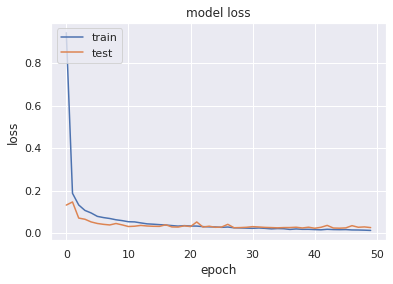

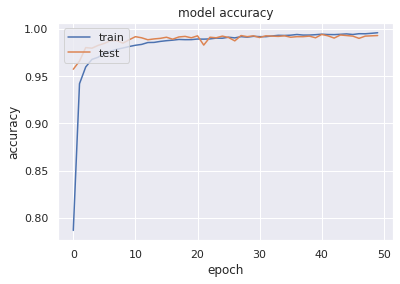

In [23]:
#loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Accuracy
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#  Accuracy: 0.9962 ;>)